In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Lambda, concatenate, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
import keras.backend as K
import pandas as pd
import json
import pickle
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
num_frames = 599
num_freq_bins = 128
dummy_data = np.random.random((num_frames, num_freq_bins))
num_conv_filters_1 = 256
kernel_size = 4

In [3]:
def l2_norm(x, axis):
    x = x ** 2
    x = K.sum(x, axis=axis)
    x = K.sqrt(x)
    return x


In [4]:
class AudioCNNModel():
    def __init__(self, num_frames, num_freq_bins, num_conv_filters1, pool_size_1, kernel_size):
        
        self.num_frames = num_frames
        self.num_freq_bins = num_freq_bins
        self.num_conv_filters1 = num_conv_filters1
        self.pool_size1 = pool_size_1
        self.kernel_size = kernel_size
        self.model_input = Input(shape=(num_frames, num_freq_bins))
        
        x = Conv1D(filters=self.num_conv_filters1, kernel_size=self.kernel_size, input_shape=(self.num_frames, self.num_freq_bins))(self.model_input)
        x = MaxPooling1D(pool_size=self.pool_size1)(x)
        x = Conv1D(filters=256, kernel_size=self.kernel_size)(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=512, kernel_size=self.kernel_size)(x)
        x = MaxPooling1D(pool_size=2)(x)

        #temporal pooling, L2, mean
        max_layer = GlobalMaxPooling1D(data_format='channels_last')(x)
        mean_layer = GlobalAveragePooling1D(data_format='channels_last')(x)
        L2_layer = Lambda(lambda x: l2_norm(x, 1))(x)
        #TODO:concatenate
        
        x = concatenate([max_layer, mean_layer, L2_layer])
        #End
        x = Dense(2048, activation='relu')(x)
        x = Dense(2048, activation='relu')(x)
#         latent_factors = Dense(50)(x)
#         popularity = Lambda(lambda x: l2_norm(x, 0))(x)
        x = Dense(50, activation='relu')(x)
        #TODO: How many genres?
        genre = Dense(15, activation='softmax')(x)
        #TODO: How to make the output?
        self.net = Model(inputs=self.model_input, outputs=genre)
        
        


In [5]:
model = AudioCNNModel(num_frames, num_freq_bins, num_conv_filters_1, 4, kernel_size)
model.net.predict(np.array([dummy_data])).shape

Instructions for updating:
Colocations handled automatically by placer.


(1, 15)

In [6]:
f = open("data/mfcc.npy", "rb")
features = np.load(f)
print(features.shape)
f.close()
features[0]

(7457, 300, 12)


array([[ 16.79 ,  85.44 , 190.534, ...,  78.221,  14.966,  -6.661],
       [ 38.132, 103.244, 213.144, ...,  14.131,   3.21 ,  14.653],
       [ 40.398,  88.145, 196.978, ...,   6.997, -19.436,  17.779],
       ...,
       [ 42.91 , -38.456,  91.888, ...,  -3.663, -23.66 ,  19.423],
       [ 54.395,  58.726, -13.786, ...,   5.575,  17.883,   0.23 ],
       [ 54.404,  58.62 , -12.292, ...,  10.572,   8.203,  -0.64 ]])

In [51]:
model = AudioCNNModel(300, 12, num_conv_filters_1, 4, kernel_size)
np.sum(model.net.predict(np.array([normalize(features[0])])))

1.0

In [13]:
with open('data/song-track-mapping.json', 'rb') as fp:
    song_track_mapping = json.load(fp)


In [14]:
with open('data/track-song-mapping.json', 'rb') as fp:
    track_song_mapping = json.load(fp)

In [15]:
print(song_track_mapping['SOSIANM12AB018CC80'], track_song_mapping['TRBBQGV12903CB5CD3'])

TRBBQGV12903CB5CD3 SOSIANM12AB018CC80


In [16]:
#df.loc[df['song'] == 'SOSIANM12AB018CC80']['features'].values

In [27]:
with open('data/song_factors.pkl', 'rb') as f:
    song_factors_dict = pickle.load(f)
np.square(np.array(song_factors_dict['SOSIANM12AB018CC80']))

array([2.86715037e-02, 6.53904872e-03, 3.78053578e-03, 2.37497606e-03,
       1.93030263e-03, 1.00197362e-02, 2.41763361e-04, 1.52440813e-02,
       2.06833737e-03, 1.95459891e-02, 7.72167145e-03, 3.58568739e-02,
       1.40177774e-03, 1.60785160e-02, 3.72594914e-05, 4.68963386e-03,
       2.02785235e-03, 1.98917638e-02, 2.12632571e-04, 2.07470238e-03,
       1.19387913e-02, 1.29230644e-03, 2.70900058e-02, 7.08668592e-03,
       2.64681244e-05, 3.89880019e-02, 2.31394499e-02, 2.50840798e-04,
       2.35546081e-04, 7.47422783e-03, 2.16228440e-03, 3.74010632e-06,
       4.89755673e-04, 1.17084796e-02, 1.51555296e-04, 1.12872599e-02,
       1.87278938e-02, 1.03272278e-02, 2.45239469e-02, 7.99537368e-02,
       1.85192951e-03, 4.61312530e-03, 8.84907565e-03, 3.01377876e-04,
       3.97853021e-02, 3.13644110e-04, 1.64920058e-03, 5.60298168e-02,
       4.44720258e-04, 3.34130625e-03])

In [31]:
track_features_dict = {}
f = open("data/track_ids_for_chroma.txt", "r")
counter = 0
for line in f:
    track_features_dict[line.strip()] = features[counter]
    counter += 1

In [20]:
model.net.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(lr=1e-5))

In [21]:
track_id_set = track_features_dict.keys()
song_id_set = list(song_factors_dict.keys())
count = 0
for song_id_key in song_id_set:
    if song_track_mapping[str(song_id_key)] not in track_id_set:
        count +=1
#         print(song_track_mapping[song_id_key])
        del song_factors_dict[song_id_key]



In [22]:
# song_factors_dict
keys = song_factors_dict.keys()
track_id_list = [song_track_mapping[key] for key in keys]
y = np.array([np.array(song_factors_dict[song_id]) for song_id in keys])
x = np.array([normalize(track_features_dict[track_id]) for track_id in track_id_list])
# x = sklearn.preprocessing.normalize(x, norm='l2', axis=1)

In [23]:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)
print(xTrain.shape, yTrain.shape)


(2188, 300, 12) (2188, 50)


In [24]:
model.net.fit(xTrain, yTrain, epochs=20, batch_size=50)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0041
Epoch 2/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0022
Epoch 3/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0021
Epoch 4/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0020
Epoch 5/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0019
Epoch 6/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0019
Epoch 7/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0019
Epoch 8/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0019
Epoch 9/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0018
Epoch 10/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.0018
Epoch 11/20
2188/2188 [==========

In [25]:
norm_y = (np.linalg.norm(yTest)**2)/yTest.shape[0]
pred = model.net.predict(xTest)
norm_pred = (np.linalg.norm(pred)**2)/pred.shape[0]
norm_y_train = (np.linalg.norm(yTrain)**2)/yTrain.shape[0]
train_pred = model.net.predict(xTrain)
# norm_pred_train = (np.linalg.norm(train_pred)**2)/train_pred.shape[0]
# avg_loss_test = (np.linalg.norm(yTest-pred)**2)/yTest.shape[0]
# loss_train = np.linalg.norm(yTrain - train_pred)**2
# avg_loss_train = loss_train/yTrain.shape[0]

    

In [26]:
avg_loss_train = np.mean(np.square(train_pred - yTrain))
avg_loss_test = np.mean(np.square(pred - yTest))
avg_pred_norm = np.mean(np.square(train_pred))
norm_y_train = np.mean(np.square(yTrain))
norm_y = np.mean(np.square(yTest))
print("average train loss",avg_loss_train)
print("average test loss", avg_loss_test)
print("average train norm",norm_y_train)
print("average test norm",norm_y)
print("average norm of predictions", avg_pred_norm)

average train loss 0.001681504540678089
average test loss 0.00146909312721303
average train norm 0.0017976001065020996
average test norm 0.0013229732227013138
average norm of predictions 0.00018282322


In [169]:
print(len(list(song_factors_dict.keys())))

2735


In [174]:
norm_sum = 0.0
for song_id in song_factors_dict.keys():
    y = np.array(song_factors_dict[song_id])
    x = track_features_dict[song_track_mapping[str(song_id_key)]]
#     y_pred = model.net.predict(np.array([x]))
    norm_sum += np.linalg.norm(y)**2
print(norm_sum)

232.8407692922114


In [234]:
model_json = model.net.to_json()
with open('params/model_params_v1.json', "w") as f:
    f.write(model_json)
model.net.save_weights("params/model_params_v1.h5")

In [10]:
#make one-hot genre encodings:
genres = {'Blues':0,
 'Country':1,
 'Electronic':2,
 'Folk':3,
 'Jazz':4,
 'Latin':5,
 'Metal':6,
 'New':7,
 'Pop':8,
 'Punk':9,
 'Rap':10,
 'Reggae':11,
 'RnB':12,
 'Rock':13,
 'World':14}

with open('data/track-genre-mapping.json', 'r') as fp:
    track_genre_dict = json.load(fp)


In [12]:
track_genre_onehot_dict = {}
f = open("data/track_ids_for_chroma.txt", "r")
track_ids = set()
counter = 0
for line in f:
    track_id = line.strip()
    genre = track_genre_dict.get(track_id)
    if genre:
        track_ids.add(track_id)
        
for track_id in track_ids:
    genre = track_genre_dict.get(track_id)
    idx = genres[genre]
    onehot = np.zeros(15)
    onehot[idx] = 1.0
    track_genre_onehot_dict[track_id] = onehot
    counter += 1
print(counter)


2367


In [52]:
track_ids = list(track_ids)
y = np.array([track_genre_onehot_dict[track_id] for track_id in track_ids])
x = np.array([normalize(track_features_dict[track_id]) for track_id in track_ids])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)
print(xTrain.shape, yTrain.shape)

(1893, 300, 12) (1893, 15)


In [53]:
model.net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])

In [60]:
history2 = model.net.fit(xTrain, yTrain, epochs=20, batch_size=50)

Epoch 1/20
1893/1893 [==============================] - 17s 9ms/step - loss: 1.1273 - acc: 0.6138
Epoch 2/20
1893/1893 [==============================] - 16s 9ms/step - loss: 1.0472 - acc: 0.6413
Epoch 3/20
1893/1893 [==============================] - 15s 8ms/step - loss: 0.9893 - acc: 0.6683
Epoch 4/20
1893/1893 [==============================] - 14s 8ms/step - loss: 0.9468 - acc: 0.6746
Epoch 5/20
1893/1893 [==============================] - 15s 8ms/step - loss: 0.9069 - acc: 0.6968
Epoch 6/20
1893/1893 [==============================] - 14s 8ms/step - loss: 0.8675 - acc: 0.7121
Epoch 7/20
1893/1893 [==============================] - 14s 8ms/step - loss: 0.8627 - acc: 0.7095
Epoch 8/20
1893/1893 [==============================] - 16s 9ms/step - loss: 0.7908 - acc: 0.7427
Epoch 9/20
1893/1893 [==============================] - 14s 7ms/step - loss: 0.7348 - acc: 0.7596
Epoch 10/20
1893/1893 [==============================] - 13s 7ms/step - loss: 0.6837 - acc: 0.7781
Epoch 11/20
1893/18

In [55]:
print(track_genre_onehot_dict['TRAACPE128F421C1B9'])
print(model.net.predict(np.array([normalize(track_features_dict['TRAACPE128F421C1B9'])])))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[[0.03680413 0.07490648 0.00480755 0.13946886 0.03112124 0.02774379
  0.00335058 0.0019536  0.22556691 0.01087562 0.02853707 0.00548039
  0.09111869 0.22674522 0.09151986]]


In [45]:
model_json = model.net.to_json()
with open('params/model_params_genre_v1.json', "w") as f:
    f.write(model_json)
model.net.save_weights("params/model_params_genre_v1.h5")

In [65]:
model.net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])
print(model.net.evaluate(xTrain, yTrain))
print(model.net.evaluate(xTest, yTest))

1893/1893 [==============================] - 4s 2ms/step
[0.2513751385706918, 0.9408346540198651]
474/474 [==============================] - 1s 2ms/step
[2.44554215946278, 0.4662447263671376]


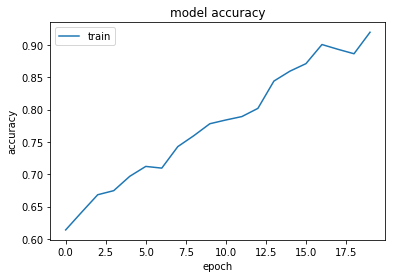

In [64]:
plt.plot(history2.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()